In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [4]:
# Import my modules.
import sys, os
from pathlib import Path
current_dir = os.path.join(Path().resolve())
sys.path.append(str(current_dir) + '/../')

from modules import utils
from modules import models
from modules import preprocess

import importlib
for m in [utils, models, preprocess]:
    importlib.reload(m)

In [5]:
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 100)
mbd = 'microbusiness_density'

In [6]:
df_train, df_test, df_subm = utils.load_dataset(subm='../submission/submission_2023-03-06_23_21_30.csv')
df_all, df_census = utils.merge_dataset(df_train, df_test, pop=False, unemploy=False, census=False, co_est=False, coord=False, 
                                        fix_pop=True, merge41=True, df_subm=df_subm, county=False, mbd_origin='before')

/tmp/working/code-analysis/../modules/utils.py:326: DtypeWarning: Columns (102) have mixed types.Specify dtype option on import or set low_memory=False.
  df_census = load_census(BASE)


merge scale=41 of df_submission to df_all.


In [7]:
df_all = df_all.reset_index()
df_subm = df_subm.reset_index().rename(columns={mbd:'mbd_pred'})
df_all = df_all.merge(df_subm, how='left', on='row_id')
df_all = df_all[df_all['scale']<=45].copy()
df_all.loc[df_all['scale']<=40, 'mbd_pred'] = np.nan

In [8]:
adult2020 = df_census.set_index('cfips')['adult_2020'].to_dict()
adult2021 = df_census.set_index('cfips')['adult_2021'].to_dict()
df_all['adult2020'] = df_all['cfips'].map(adult2020)
df_all['adult2021'] = df_all['cfips'].map(adult2021)
idx = df_all[mbd].isna()
df_all.loc[idx, mbd] = df_all.loc[idx, 'mbd_pred'] * df_all.loc[idx, 'adult2021'] / df_all.loc[idx, 'adult2020']
df_all = df_all.drop(['adult2020', 'adult2021'], axis=1)

In [9]:
dict_county = df_all[['cfips', 'county', 'state']].drop_duplicates().set_index('cfips').to_dict()

def plot_mbd_with_active(cfips_list, pred_m=1):
    n = len(cfips_list)

    column = 4
    row = math.ceil(n / 4)
    fig, axes = plt.subplots(row, column, tight_layout=True, figsize=(column*5,row*6))
    axes = axes.ravel()

    for i in range(n):
        ax = axes[i]

        cfips = cfips_list[i]
        df = df_all[df_all['cfips']==cfips]
        xlabel = f'{cfips}_{dict_county["county"][cfips]}_{dict_county["state"][cfips]}'
        lastactive = df['active'][df['scale']==40].values[0]

        sns.lineplot(x='scale', y=mbd,  data=df, ax=ax, label='mbd')
        ax.axvline(x=41, ymin=0, ymax=3)
        if pred_m:
            sns.lineplot(x='scale', y=f'mbd_pred', data=df, ax=ax, label=f'pred{pred_m}')
        ax.set_xlabel(xlabel, fontsize=12)
        ax.legend(loc='upper left')
        ax.text(0.04, 0.85, f'active = {lastactive}', transform=ax.transAxes, fontsize=12)
    
    plt.show()

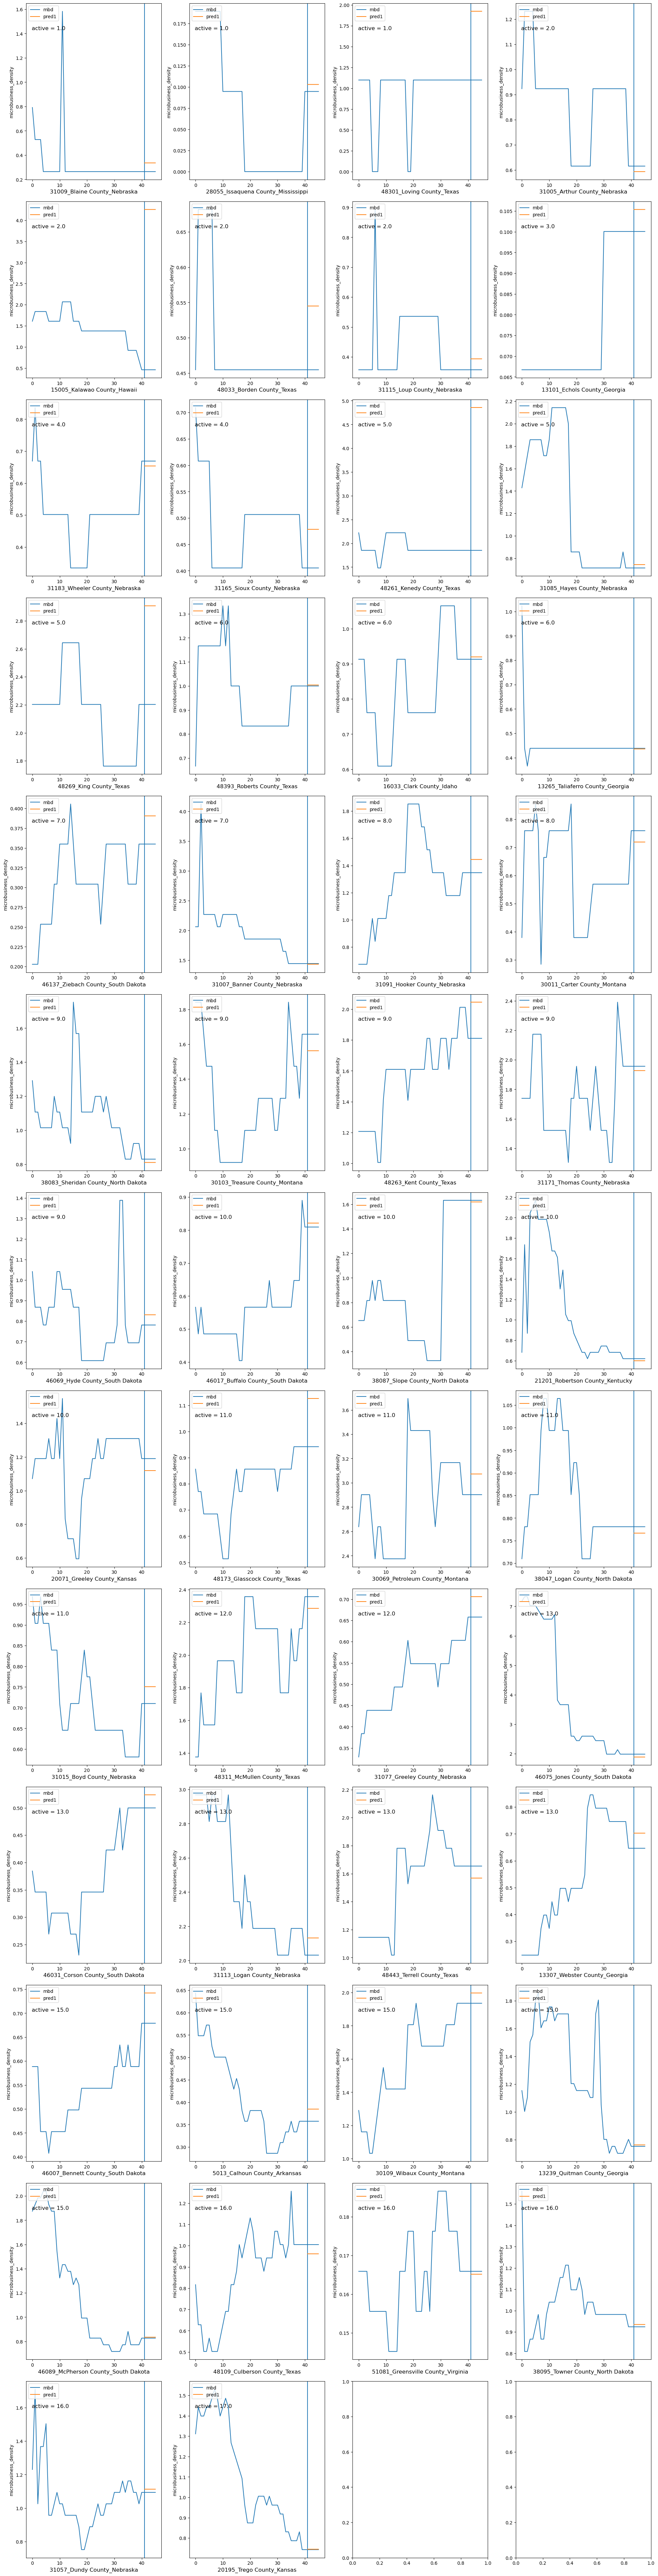

In [10]:
# 微調整リスト(ここから変化がありそうなcfipsをいじる)
plot_mbd_with_active([31009,
 28055,
 48301,
 31005,
 15005,
 48033,
 31115,
 13101,
 31183,
 31165,
 48261,
 31085,
 48269,
 48393,
 16033,
 13265,
 46137,
 31007,
 31091,
 30011,
 38083,
 30103,
 48263,
 31171,
 46069,
 46017,
 38087,
 21201,
 20071,
 48173,
 30069,
 38047,
 31015,
 48311,
 31077,
 46075,
 46031,
 31113,
 48443,
 13307,
 46007,
 5013,
 30109,
 13239,
 46089,
 48109,
 51081,
 38095,
 31057,
 20195])

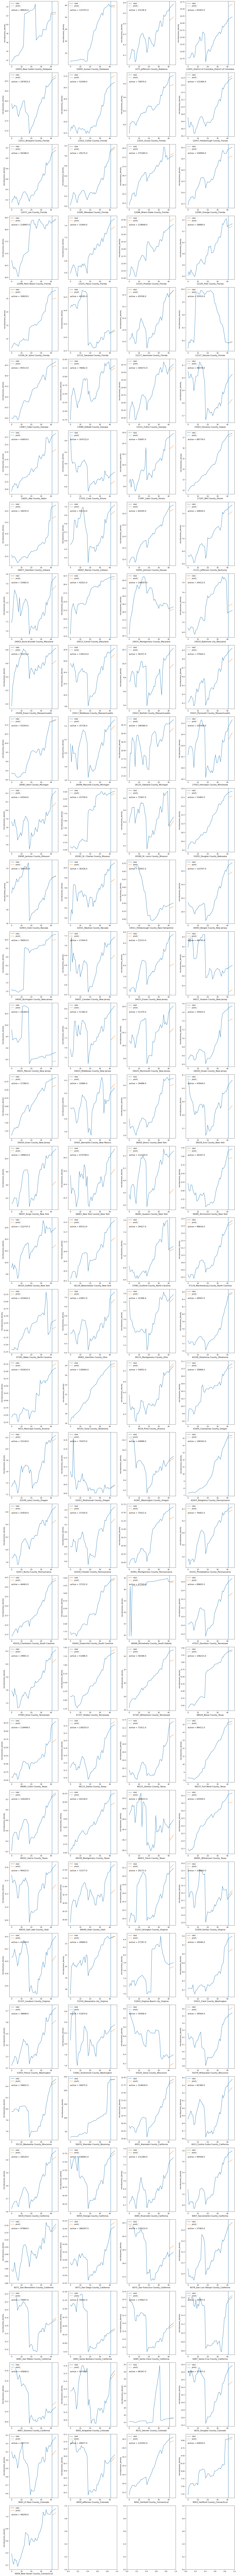

In [11]:
#トレンドの群
trend_active25000 = [10003, 10005,  1073, 11001, 12011, 12021, 12031, 12057, 12071,
       12081, 12086, 12095, 12099, 12101, 12103, 12105, 12109, 12115,
       12117, 12127, 13067, 13089, 13121, 15003, 16001, 17031, 17097,
       17197, 18057, 18097, 20091, 21111, 24003, 24013, 24031, 24510,
       25009, 25017, 25021, 25023, 26081, 26099, 26125, 27053, 29095,
       29183, 29189, 31055, 32003, 32031, 33011, 34003, 34005, 34007,
       34013, 34017, 34021, 34023, 34025, 34029, 34039, 35001, 36005,
       36029, 36047, 36061, 36081, 36085, 36103, 36119, 37081, 37119,
       37183, 39061, 39113, 40109,  4013, 40143,  4019, 41005, 41039,
       41051, 41067, 42003, 42017, 42029, 42091, 42101, 45019, 45045,
       46099, 47037, 47093, 47157, 47187, 48029, 48085, 48113, 48121,
       48157, 48201, 48339, 48453, 48491, 49035, 49049, 51013, 51059,
       51107, 51510, 51810, 53011, 53053, 53061, 55025, 55079, 55133,
       56033,  6001,  6013,  6019,  6059,  6065,  6067,  6071,  6073,
        6075,  6079,  6081,  6083,  6085,  6087,  6097,  8005,  8031,
        8035,  8041,  8059,  9001,  9003,  9009]

plot_mbd_with_active(trend_active25000)

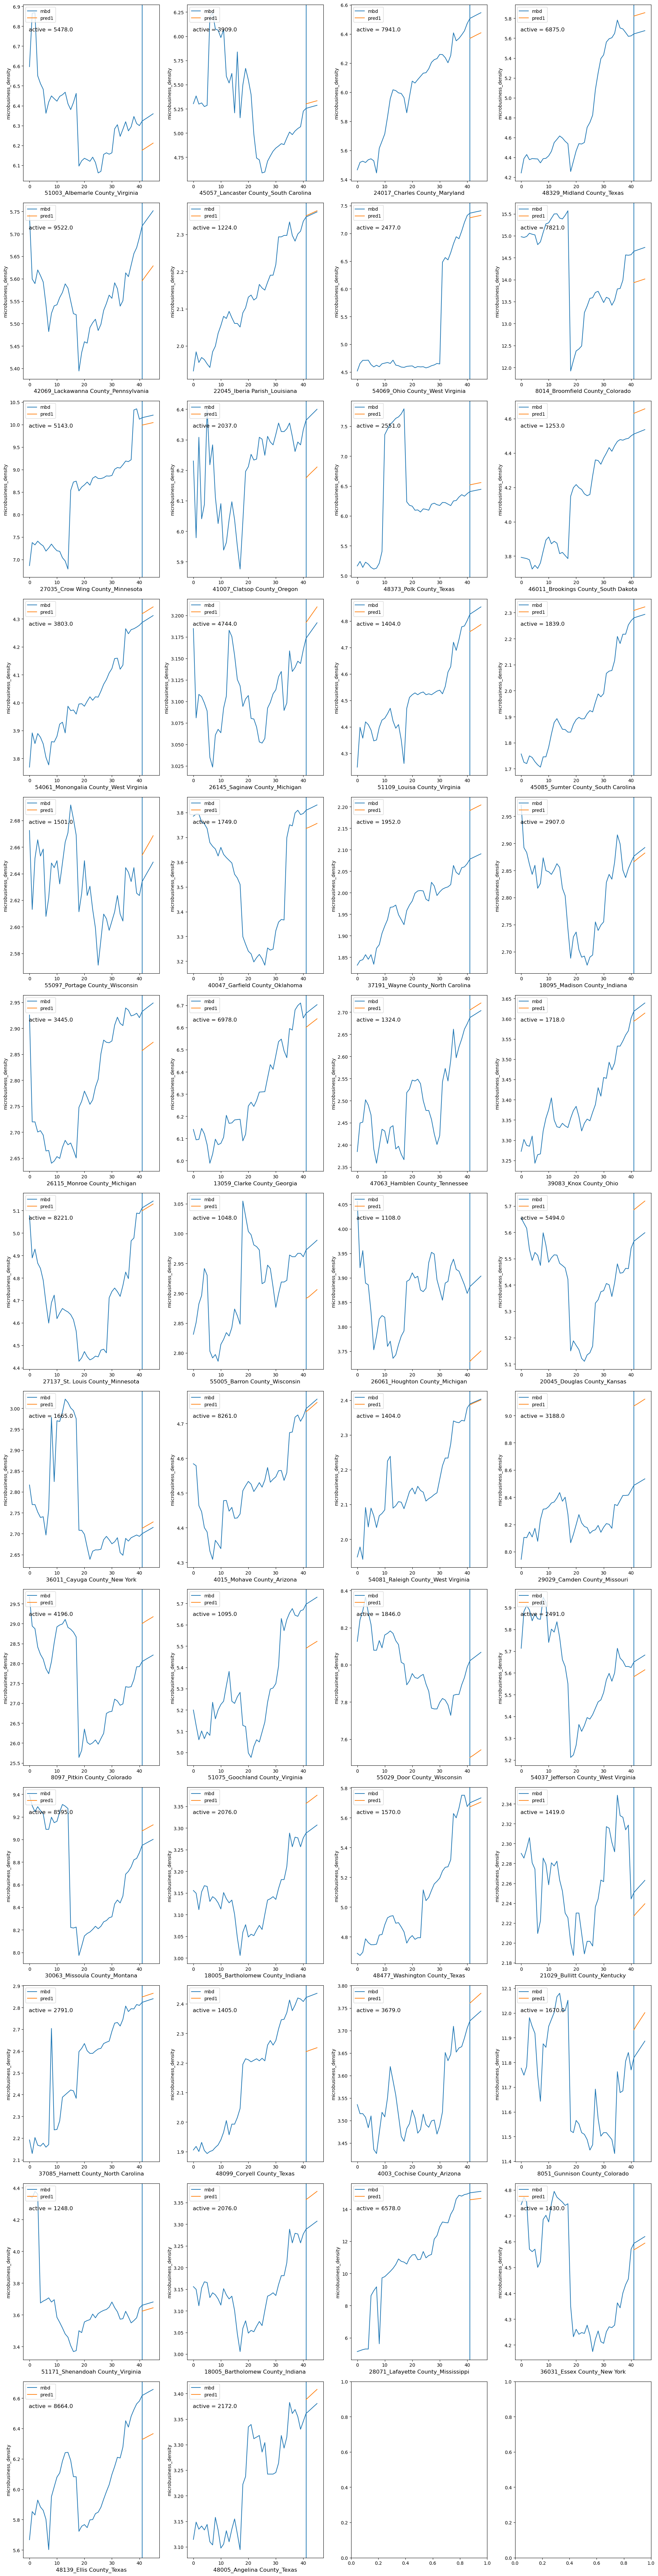

In [13]:
# active 1000 to 10000のランダム
random_list = [51003, 45057, 24017, 48329, 42069, 22045, 54069, 8014, 27035, 41007, 48373, 46011, 54061, 26145, 51109, 45085, 55097, 40047,
 37191, 18095, 26115, 13059, 47063, 39083, 27137, 55005, 26061, 20045, 36011, 4015, 54081, 29029, 8097, 51075, 55029, 54037, 30063, 18005,
 48477, 21029, 37085, 48099, 4003, 8051, 51171, 18005, 28071, 36031, 48139, 48005]

plot_mbd_with_active(random_list)